In [5]:
import pandas as pd

data = pd.read_csv("./archive/wsj_headlines.csv")

print("Loaded DataFrame:")
display(data.head())

Loaded DataFrame:


,Unnamed: 0,Date,Headline,Category
0,0,01/26/2012,Mother Nature Raps Natural Gas,Markets
1,1,06/15/2007,Subprime Woes Pinch Bear's Mortgage Star,US Business News
2,2,01/24/2011,Facebook Alters Tool in German Privacy Deal,Technology
3,3,02/20/2014,EU Ministers Clear Sanctions on Ukraine,World News
4,4,01/09/2011,Authorities Seek Possible Associate of Suspect,Politics


In [6]:
from textblob import TextBlob

# Define a function to compute sentiment using TextBlob
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply TextBlob sentiment to the 'Headline' column
data['TextBlob_Sentiment'] = data['Headline'].apply(get_textblob_sentiment)


In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Define a function to compute sentiment using VADER
def get_vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound']

# Apply VADER sentiment to the 'Headline' column
data['VADER_Sentiment'] = data['Headline'].apply(get_vader_sentiment)


In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from tqdm import tqdm

# Load the pretrained model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define a function for BERT sentiment analysis
def bert_sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    sentiment_score = torch.argmax(scores).item()  # Get the index of the highest score
    confidence = torch.max(scores).item()          # Get the confidence score
    return sentiment_score, confidence


In [9]:

# Apply BERT sentiment analysis in batches with a progress bar
sentiments = []
confidences = []

for text in tqdm(data['Headline'], desc="Analyzing Sentiment"):
    try:
        sentiment, confidence = bert_sentiment_analysis(text)
        sentiments.append(sentiment)
        confidences.append(confidence)
    except Exception as e:
        print(f"Error processing text: {text}\nError: {e}")
        sentiments.append(None)
        confidences.append(None)

data['BERT_Sentiment_Label'] = sentiments
data['BERT_Sentiment_Score'] = confidences

# Save the updated DataFrame to a CSV file
output_file = "./archive/wsj_headlines_with_sentiment.csv"
data.to_csv(output_file, index=False)
print(f"Sentiment analysis complete. Results saved to {output_file}")

Analyzing Sentiment: 100%|██████████| 19227/19227 [16:54<00:00, 18.95it/s]


Sentiment analysis complete. Results saved to ./archive/wsj_headlines_with_sentiment.csv


In [55]:
df = pd.read_csv("./archive/wsj_headlines_with_sentiment.csv")

print("Loaded DataFrame:")
display(df.head())



Loaded DataFrame:


,Unnamed: 0,Date,Headline,Category,TextBlob_Sentiment,VADER_Sentiment,BERT_Sentiment_Label,BERT_Sentiment_Score
0,0,01/26/2012,Mother Nature Raps Natural Gas,Markets,0.1,0.3612,4,0.293945
1,1,06/15/2007,Subprime Woes Pinch Bear's Mortgage Star,US Business News,0.0,-0.4404,0,0.287087
2,2,01/24/2011,Facebook Alters Tool in German Privacy Deal,Technology,0.0,0.0000,0,0.517856
3,3,02/20/2014,EU Ministers Clear Sanctions on Ukraine,World News,0.1,0.3818,3,0.228783
4,4,01/09/2011,Authorities Seek Possible Associate of Suspect,Politics,0.0,-0.2960,0,0.429186


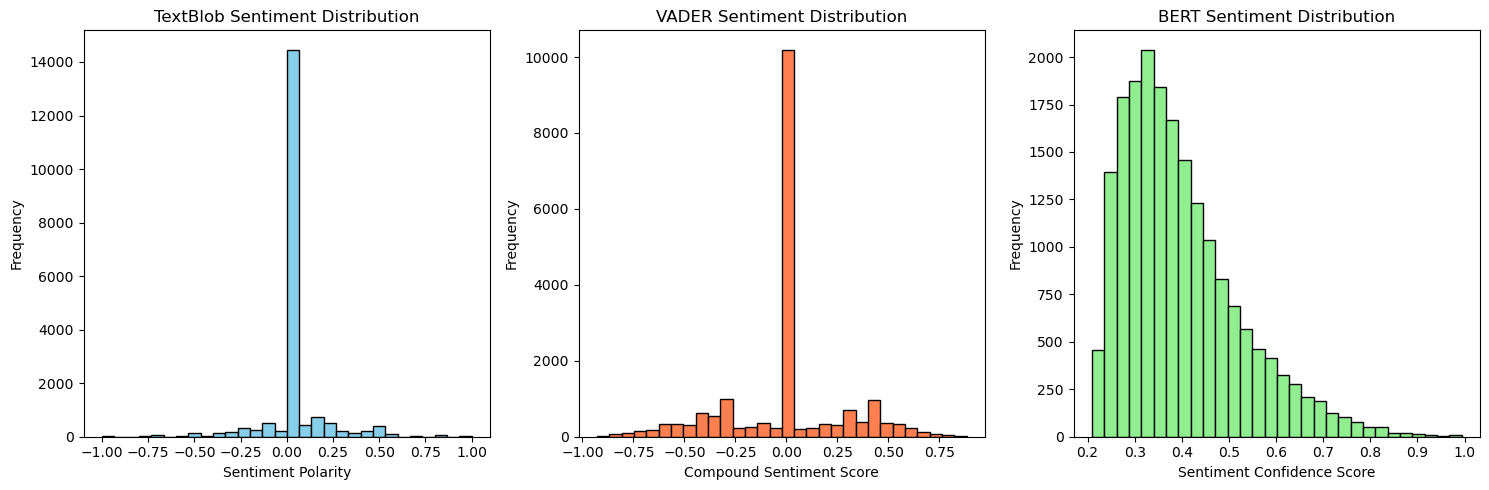

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# TextBlob Sentiment
plt.subplot(1, 3, 1)
plt.hist(df['TextBlob_Sentiment'], bins=30, color='skyblue', edgecolor='black')
plt.title("TextBlob Sentiment Distribution")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")

# VADER Sentiment
plt.subplot(1, 3, 2)
plt.hist(df['VADER_Sentiment'], bins=30, color='coral', edgecolor='black')
plt.title("VADER Sentiment Distribution")
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Frequency")

# BERT Sentiment
plt.subplot(1, 3, 3)
plt.hist(df['BERT_Sentiment_Score'], bins=30, color='lightgreen', edgecolor='black')
plt.title("BERT Sentiment Distribution")
plt.xlabel("Sentiment Confidence Score")
plt.ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()


In [63]:
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv("./archive/wsj_headlines_with_sentiment.csv")

# Initialize MinMaxScaler for range -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the sentiment columns
df['Scaled_TextBlob_Sentiment'] = scaler.fit_transform(df[['TextBlob_Sentiment']])
df['Scaled_VADER_Sentiment'] = scaler.fit_transform(df[['VADER_Sentiment']])
df['Scaled_BERT_Sentiment_Score'] = scaler.fit_transform(df[['BERT_Sentiment_Score']])

# Display the first few rows to verify the new scaled columns
print("DataFrame with scaled sentiment columns:")
display(df.head())


DataFrame with scaled sentiment columns:


,Unnamed: 0,Date,Headline,Category,TextBlob_Sentiment,VADER_Sentiment,BERT_Sentiment_Label,BERT_Sentiment_Score,Scaled_TextBlob_Sentiment,Scaled_VADER_Sentiment,Scaled_BERT_Sentiment_Score
0,0,01/26/2012,Mother Nature Raps Natural Gas,Markets,0.1,0.3612,4,0.293945,0.1,0.423238,-0.784493
1,1,06/15/2007,Subprime Woes Pinch Bear's Mortgage Star,US Business News,0.0,-0.4404,0,0.287087,0.0,-0.462116,-0.801983
2,2,01/24/2011,Facebook Alters Tool in German Privacy Deal,Technology,0.0,0.0000,0,0.517856,0.0,0.024299,-0.213413
3,3,02/20/2014,EU Ministers Clear Sanctions on Ukraine,World News,0.1,0.3818,3,0.228783,0.1,0.445991,-0.950687
4,4,01/09/2011,Authorities Seek Possible Associate of Suspect,Politics,0.0,-0.2960,0,0.429186,0.0,-0.302629,-0.439564


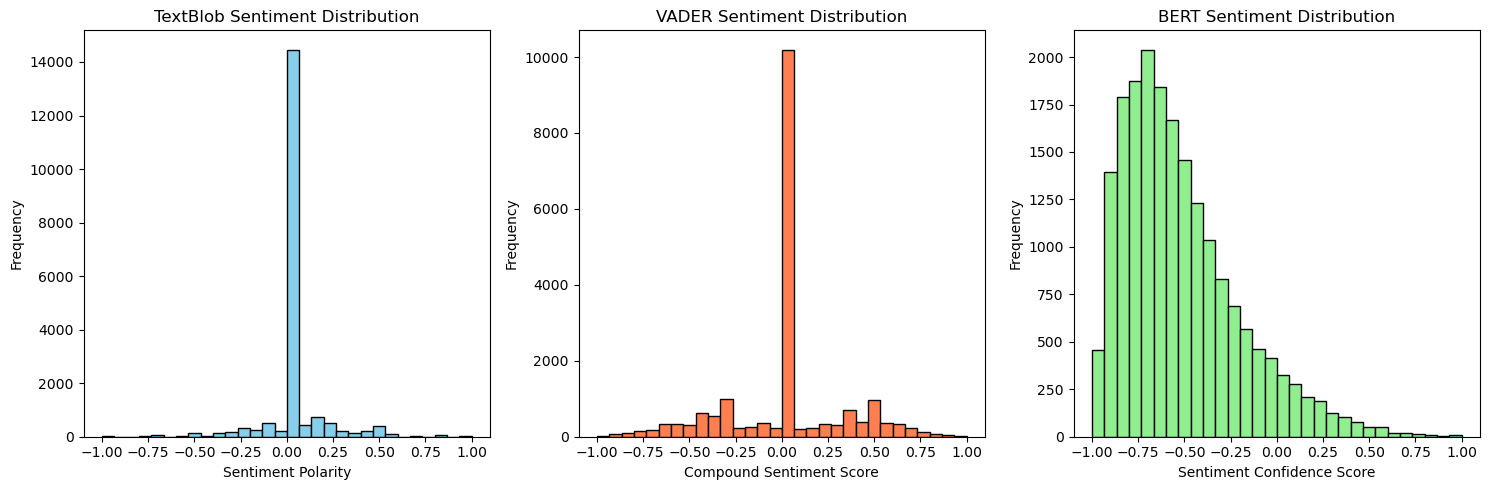

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# TextBlob Sentiment
plt.subplot(1, 3, 1)
plt.hist(df['Scaled_TextBlob_Sentiment'], bins=30, color='skyblue', edgecolor='black')
plt.title("TextBlob Sentiment Distribution")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")

# VADER Sentiment
plt.subplot(1, 3, 2)
plt.hist(df['Scaled_VADER_Sentiment'], bins=30, color='coral', edgecolor='black')
plt.title("VADER Sentiment Distribution")
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Frequency")

# BERT Sentiment
plt.subplot(1, 3, 3)
plt.hist(df['Scaled_BERT_Sentiment_Score'], bins=30, color='lightgreen', edgecolor='black')
plt.title("BERT Sentiment Distribution")
plt.xlabel("Sentiment Confidence Score")
plt.ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

In [60]:
import yfinance as yf
import pandas as pd

# Load the dataset with headlines
df = pd.read_csv("./archive/wsj_headlines_with_sentiment.csv")

# Get the start and end dates from the dataset
start_date = pd.to_datetime(df['Date']).min().strftime('%Y-%m-%d')
end_date = pd.to_datetime(df['Date']).max().strftime('%Y-%m-%d')

# Fetch S&P 500 data from Yahoo Finance with monthly intervals
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(start=start_date, end=end_date, interval="1mo")  # Monthly intervals

# Extract only the closing price
monthly_closing_prices = sp500_data[['Close']]

# Reset the index to have Date as a column for easier merging/inspection
monthly_closing_prices.reset_index(inplace=True)
monthly_closing_prices['Date'] = monthly_closing_prices['Date'].dt.strftime('%Y-%m')

# Display the first few rows of the monthly closing prices
print("Monthly Closing Prices of S&P 500:")
print(monthly_closing_prices.head())


Monthly Closing Prices of S&P 500:
      Date        Close
0  1998-02  1049.339966
1  1998-03  1101.750000
2  1998-04  1111.750000
3  1998-05  1090.819946
4  1998-06  1133.839966


/var/folders/rp/g4tg7sg164bcfkxk2nc79c3r0000gn/T/ipykernel_44748/4285241973.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_closing_prices['Date'] = monthly_closing_prices['Date'].dt.strftime('%Y-%m')


In [62]:
print(df.columns)


Index(['Unnamed: 0', 'Date', 'Headline', 'Category', 'TextBlob_Sentiment',
       'VADER_Sentiment', 'BERT_Sentiment_Label', 'BERT_Sentiment_Score',
       'YearMonth'],
      dtype='object')


In [66]:
# Ensure the 'Date' column in the headlines DataFrame is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month for grouping
df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)

# Group by YearMonth and calculate the average scaled sentiment scores
monthly_sentiments = df.groupby('YearMonth').agg({
    'Scaled_TextBlob_Sentiment': 'mean',
    'Scaled_VADER_Sentiment': 'mean',
    'Scaled_BERT_Sentiment_Score': 'mean'
}).reset_index()


In [67]:
# Ensure the monthly closing prices DataFrame is a new copy to avoid SettingWithCopyWarning
monthly_closing_prices = monthly_closing_prices.copy()

# Add 'YearMonth' column in YYYY-MM format
monthly_closing_prices['YearMonth'] = monthly_closing_prices['Date']

# Drop the 'Date' column
monthly_closing_prices.drop(columns=['Date'], inplace=True)

# Merge the sentiment DataFrame with the S&P 500 monthly closing prices
final_monthly_df = pd.merge(monthly_sentiments, monthly_closing_prices, on='YearMonth', how='inner')

# Display the new DataFrame
print("Final Monthly DataFrame:")
display(final_monthly_df.head())

# Save the final DataFrame to a CSV file for future use
final_monthly_df.to_csv("./final_monthly_data.csv", index=False)
print("Data saved to 'final_monthly_data.csv'")

Final Monthly DataFrame:


,YearMonth,Scaled_TextBlob_Sentiment,Scaled_VADER_Sentiment,Scaled_BERT_Sentiment_Score,Close
0,1998-02,0.000000,0.024299,-0.833554,1049.339966
1,1998-03,0.000000,0.024299,-0.558325,1101.750000
2,1998-05,0.022033,0.001093,-0.575734,1090.819946
3,1998-06,-0.002160,0.005467,-0.598431,1133.839966
4,1998-07,0.020761,0.050816,-0.529439,1120.670044


Data saved to 'final_monthly_data.csv'


In [68]:
from sklearn.preprocessing import MinMaxScaler

# Merge the monthly sentiments with S&P500 closing prices
final_monthly_df = pd.merge(monthly_sentiments, monthly_closing_prices, on='YearMonth', how='inner')

# Initialize MinMaxScaler for range -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the S&P500 monthly closing prices
final_monthly_df['Scaled_SP500_Close'] = scaler.fit_transform(final_monthly_df[['Close']])

# Display the updated DataFrame
print("Final Monthly DataFrame with Scaled S&P500 Closing Prices:")
display(final_monthly_df.head())


Final Monthly DataFrame with Scaled S&P500 Closing Prices:


,YearMonth,Scaled_TextBlob_Sentiment,Scaled_VADER_Sentiment,Scaled_BERT_Sentiment_Score,Close,Scaled_SP500_Close
0,1998-02,0.000000,0.024299,-0.833554,1049.339966,-0.823575
1,1998-03,0.000000,0.024299,-0.558325,1101.750000,-0.794151
2,1998-05,0.022033,0.001093,-0.575734,1090.819946,-0.800287
3,1998-06,-0.002160,0.005467,-0.598431,1133.839966,-0.776135
4,1998-07,0.020761,0.050816,-0.529439,1120.670044,-0.783529


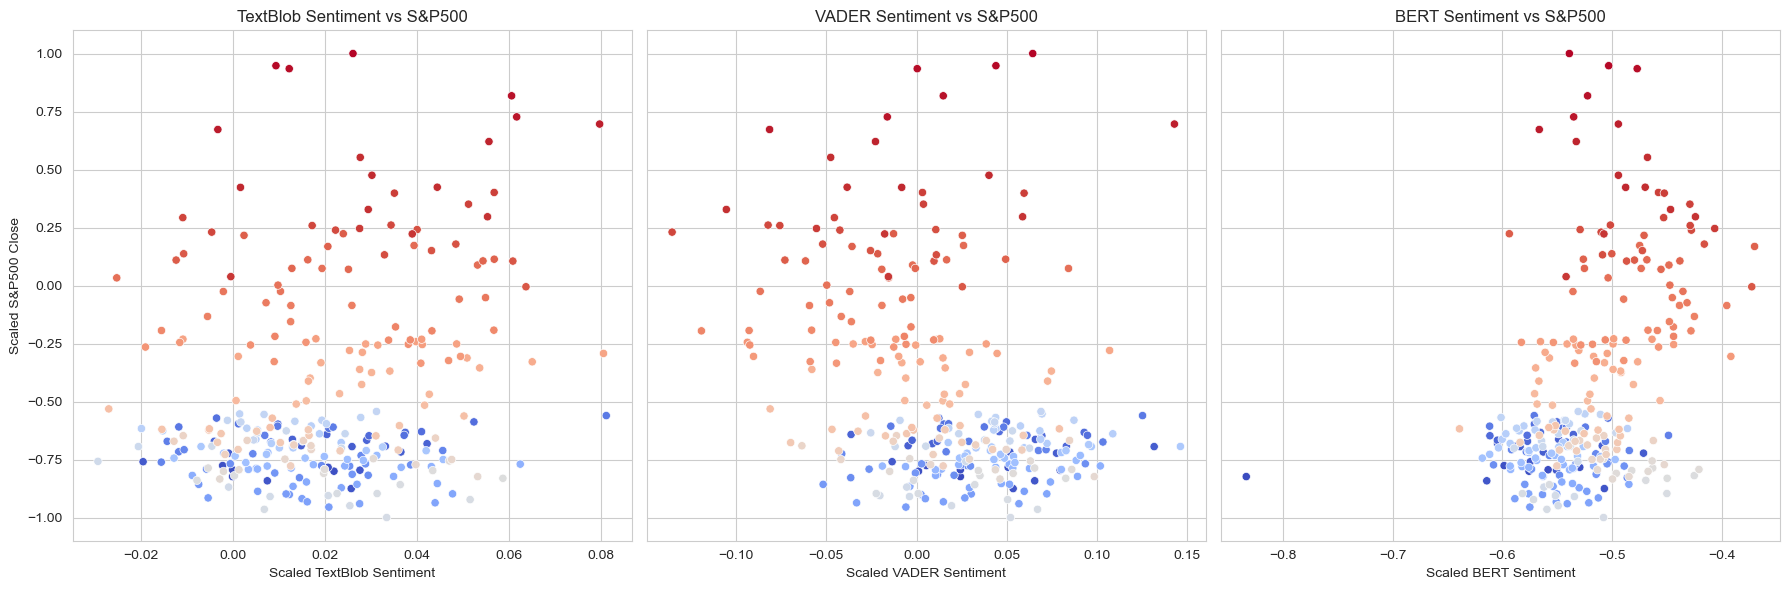

In [71]:
import seaborn as sns
final_monthly_df['YearMonth'] = pd.to_datetime(final_monthly_df['YearMonth'])

# Set up the plotting area with 3 side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.set_style("whitegrid")

# Plot 1: Scaled TextBlob Sentiment vs Scaled S&P500 with hue as date
sns.scatterplot(
    data=final_monthly_df,
    x='Scaled_TextBlob_Sentiment',
    y='Scaled_SP500_Close',
    hue='YearMonth',
    palette='coolwarm',
    ax=axes[0],
    legend=False
)
axes[0].set_title("TextBlob Sentiment vs S&P500", fontsize=12)
axes[0].set_xlabel("Scaled TextBlob Sentiment")
axes[0].set_ylabel("Scaled S&P500 Close")

# Plot 2: Scaled VADER Sentiment vs Scaled S&P500 with hue as date
sns.scatterplot(
    data=final_monthly_df,
    x='Scaled_VADER_Sentiment',
    y='Scaled_SP500_Close',
    hue='YearMonth',
    palette='coolwarm',
    ax=axes[1],
    legend=False
)
axes[1].set_title("VADER Sentiment vs S&P500", fontsize=12)
axes[1].set_xlabel("Scaled VADER Sentiment")
axes[1].set_ylabel("")

# Plot 3: Scaled BERT Sentiment vs Scaled S&P500 with hue as date
sns.scatterplot(
    data=final_monthly_df,
    x='Scaled_BERT_Sentiment_Score',
    y='Scaled_SP500_Close',
    hue='YearMonth',
    palette='coolwarm',
    ax=axes[2],
    legend=False
)
axes[2].set_title("BERT Sentiment vs S&P500", fontsize=12)
axes[2].set_xlabel("Scaled BERT Sentiment")
axes[2].set_ylabel("")

# Adjust the layout for better appearance
plt.tight_layout()
plt.show()


In [ ]:
# Check if the scaled sentiment scores are within the range [-1, 1]
sentiment_columns = [
    'Scaled_TextBlob_Sentiment',
    'Scaled_VADER_Sentiment',
    'Scaled_BERT_Sentiment_Score'
]

for col in sentiment_columns:
    min_val = final_monthly_df[col].min()
    max_val = final_monthly_df[col].max()
    print(f"{col}: Min = {min_val}, Max = {max_val}")

# Check if any values are outside the range [-1, 1]
for col in sentiment_columns:
    out_of_range = final_monthly_df[(final_monthly_df[col] < -1) | (final_monthly_df[col] > 1)]
    if not out_of_range.empty:
        print(f"{col} has values outside the range [-1, 1]:")
        display(out_of_range)
    else:
        print(f"All values in {col} are within the range [-1, 1].")


In [73]:
# Ensure 'YearMonth' is sorted in ascending order
final_monthly_df = final_monthly_df.sort_values(by='YearMonth')

# Extract the year from 'YearMonth' for splitting
final_monthly_df['Year'] = final_monthly_df['YearMonth'].dt.year

# Define the cutoff year for train-test split
test_start_year = final_monthly_df['Year'].max() - 4

# Create train and test datasets based on the cutoff year
train_data = final_monthly_df[final_monthly_df['Year'] < test_start_year]
test_data = final_monthly_df[final_monthly_df['Year'] >= test_start_year]

# Drop the 'Year' column as it's not needed for modeling
train_data = train_data.drop(columns=['Year'])
test_data = test_data.drop(columns=['Year'])

# Display the split information
print(f"Train data: {len(train_data)} rows")
print(f"Test data: {len(test_data)} rows")
display(train_data.head())
display(test_data.head())


Train data: 226 rows
Test data: 54 rows


,YearMonth,Scaled_TextBlob_Sentiment,Scaled_VADER_Sentiment,Scaled_BERT_Sentiment_Score,Close,Scaled_SP500_Close
0,1998-02-01,0.000000,0.024299,-0.833554,1049.339966,-0.823575
1,1998-03-01,0.000000,0.024299,-0.558325,1101.750000,-0.794151
2,1998-05-01,0.022033,0.001093,-0.575734,1090.819946,-0.800287
3,1998-06-01,-0.002160,0.005467,-0.598431,1133.839966,-0.776135
4,1998-07-01,0.020761,0.050816,-0.529439,1120.670044,-0.783529


,YearMonth,Scaled_TextBlob_Sentiment,Scaled_VADER_Sentiment,Scaled_BERT_Sentiment_Score,Close,Scaled_SP500_Close
226,2017-01-01,-0.005438,-0.041748,-0.424949,2278.870117,-0.133295
227,2017-02-01,0.025933,-0.019179,-0.438505,2363.639893,-0.085703
228,2017-03-01,0.012665,-0.059353,-0.395419,2362.719971,-0.086220
229,2017-04-01,0.007272,-0.048258,-0.431637,2384.199951,-0.074161
230,2017-05-01,0.049252,-0.007688,-0.489445,2411.800049,-0.058665


Accuracy on test set: 0.5535714285714286

Classification Report:
              precision    recall  f1-score   support

         0.0       0.12      0.15      0.14        13
         1.0       0.72      0.67      0.70        43

    accuracy                           0.55        56
   macro avg       0.42      0.41      0.42        56
weighted avg       0.59      0.55      0.57        56


Confusion Matrix:
[[ 2 11]
 [14 29]]


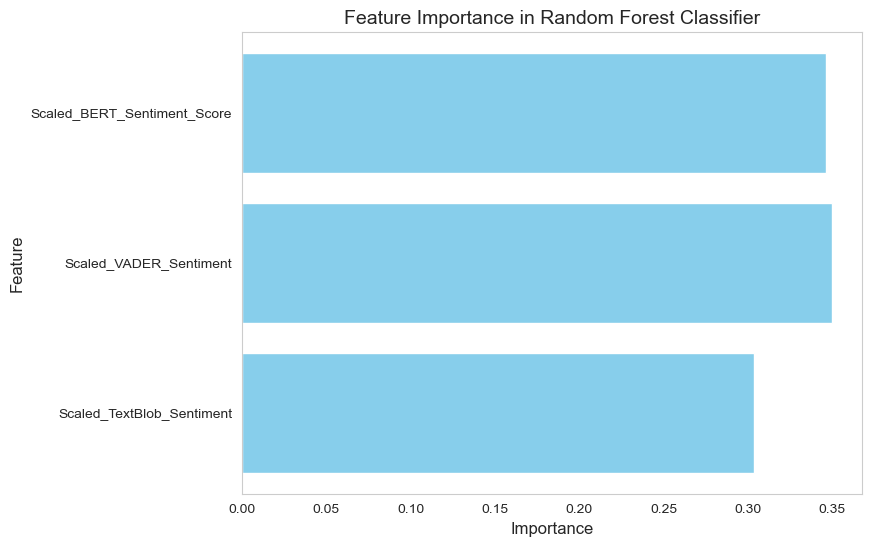

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the target: 'Buy' or 'Sell' based on S&P500 close price changes
final_monthly_df['Target'] = (final_monthly_df['Close'].diff() > 0).astype(int)  # 1 for Buy (price went up), 0 for Sell (price went down)
final_monthly_df['Target'] = final_monthly_df['Target'].shift(-1)  # Shift to align with next month's decision
final_monthly_df = final_monthly_df.dropna(subset=['Target'])  # Drop rows with NaN in the target column

# Define features and target
feature_columns = ['Scaled_TextBlob_Sentiment', 'Scaled_VADER_Sentiment', 'Scaled_BERT_Sentiment_Score']
X = final_monthly_df[feature_columns]
y = final_monthly_df['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced'
)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot feature importance
import matplotlib.pyplot as plt

feature_importances = rf_classifier.feature_importances_
plt.figure(figsize=(8, 6))
plt.barh(feature_columns, feature_importances, color='skyblue')
plt.title("Feature Importance in Random Forest Classifier", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid()
plt.show()


In [82]:
# Recreate the test data from the original DataFrame
test_data = final_monthly_df.iloc[-len(y_pred):].copy()  # Use the last rows corresponding to the predictions

# Add predictions and actual percentage changes to the test dataset
test_data['Predicted_Action'] = y_pred  # Add predictions
test_data['Actual_Change'] = test_data['Close'].pct_change()  # Actual percentage change
test_data = test_data.dropna(subset=['Actual_Change'])  # Drop rows with NaN in 'Actual_Change'

# Simulate returns
test_data['Simulated_Return'] = test_data.apply(
    lambda row: row['Actual_Change'] if row['Predicted_Action'] == 1 else 0,
    axis=1
)

# Calculate cumulative returns
cumulative_return = test_data['Simulated_Return'].sum()
print(f"Cumulative Return from Trading Strategy: {cumulative_return:.2%}")

# Compare with buy-and-hold strategy
buy_and_hold_return = test_data['Actual_Change'].sum()
print(f"Cumulative Return from Buy-and-Hold Strategy: {buy_and_hold_return:.2%}")

# Display key stats and check test_data structure
print("\nSimulated Test Data:")
display(test_data.head())


Cumulative Return from Trading Strategy: 81.41%
Cumulative Return from Buy-and-Hold Strategy: 74.06%

Simulated Test Data:


,YearMonth,Scaled_TextBlob_Sentiment,Scaled_VADER_Sentiment,Scaled_BERT_Sentiment_Score,Close,Scaled_SP500_Close,Year,Target,Pct_Change,Predicted_Action,Actual_Change,Simulated_Return
224,2016-11-01,0.035414,-0.003068,-0.444069,2198.810059,-0.178242,2016,1.0,0.034175,1.0,0.034175,0.034175
225,2016-12-01,0.012621,-0.036126,-0.447749,2238.830078,-0.155774,2016,1.0,0.018201,1.0,0.018201,0.018201
226,2017-01-01,-0.005438,-0.041748,-0.424949,2278.870117,-0.133295,2017,1.0,0.017884,0.0,0.017884,0.000000
227,2017-02-01,0.025933,-0.019179,-0.438505,2363.639893,-0.085703,2017,0.0,0.037198,1.0,0.037198,0.037198
228,2017-03-01,0.012665,-0.059353,-0.395419,2362.719971,-0.086220,2017,1.0,-0.000389,0.0,-0.000389,0.000000
